# Návod: Pohled na stavební a penzijní spoření

V následujících řádcích se pokusíme ilustrovat použití otevřených dat publikovaných na našem portálu. Konkrétně půjde o datové sady [Vývoj stavebního spoření](https://data.mf.gov.cz/topics/stavebni-sporeni.html) a [Penzijní připojištění a spoření](https://data.mf.gov.cz/topics/penzijni.html) a jejich zpracování bude prezentováno v programovacím jazyce Python. Mimo to se zde pokusíme poukázat na problémy, které se zpracováním dat souvisejí a které se neomezují pouze na tyto dvě datové sady.

Zabývat se budeme především tím, jak se do dat promítly konkrétní události a jaké trendy můžeme vypozorovat. Také budeme zkoumat, zdali spolu tato data nějak souvisí, tedy jestli se sklon k ukládání úspor formou stavebního spoření vyvíjí v čase podobně, jako je tomu u spoření penzijního.

## Stavební spoření

Nahrajeme data přímo z našeho portálu a podíváme se na jejich strukturu:

In [1]:
import pandas as pd
stavebni=pd.read_csv("https://data.mf.gov.cz/exports/stavebni_sporeni/csv").sort_values(["rok","ctvrtleti"]).reset_index()
stavebni.dtypes

index                          int64
rok                            int64
ctvrtleti                      int64
nove_smlouvy                   int64
prumerna_cilova_castka       float64
smlouvy_sporeni                int64
statni_podpora                 int64
prumerna_podpora             float64
nasporena_castka               int64
uvery_celkem                   int64
uvery_ss                       int64
uvery_preklenovaci             int64
uvery_castka_celkem            int64
uvery_castka_ss                int64
uvery_castka_preklenovaci      int64
dtype: object

Z tohoto přehledu, stejně jako ze struktury dat na [našem portálu](https://data.mf.gov.cz/topics/stavebni-sporeni.html), víme, že každý záznam je identifikován rokem a čtvrtletím. Koukneme se tedy, které jejich kombinace v datové sadě jsou:

In [2]:
stavebni[["rok","ctvrtleti"]].head()

,rok,ctvrtleti
0,1997,4
1,1998,4
2,1999,4
3,2000,4
4,2001,4


In [3]:
stavebni[stavebni.ctvrtleti!=4][["rok","ctvrtleti"]].head()

,rok,ctvrtleti
11,2008,1
12,2008,2
13,2008,3
15,2009,1
16,2009,2


Zde vidíme první možný problém: z datové sady lze extrahovat více časových řad, v tomto případě podle frekvence záznamů. Jelikož jsou záznamy za čtvrtletí dostupná pouze od roku 2008, je třeba pro každé zkoumání zvážit, zdali je důležitější délka časového období, nebo naopak vyšší frekvence záznamů.

Pokud bychom chtěli data čtvrtletní, je vhodné poznamenat, že pro časovou řadu veličin závisejících na časovém období (tzv. flow variables) je třeba data řádně upravit. To proto, že každý takový záznam značí období mezi začátkem roku a koncem daného čtvrtletí, nikoli období čtvrtletí samotného. Toto platí například pro počty nových smluv. Potřebná transformace lze pak provést třeba takto:

In [4]:
import numpy as np
nove_smlouvy_v_obdobi=[]
for i in range(len(stavebni)):
    if stavebni.ctvrtleti[i]==1:
        nove=stavebni.nove_smlouvy[i]
    elif i-1 in stavebni[stavebni["rok"]==stavebni.rok[i]].ctvrtleti:
        nove=stavebni.nove_smlouvy[i]-stavebni.nove_smlouvy[i-1]
    else:
        nove=np.NaN
    nove_smlouvy_v_obdobi.append(nove)

stavebni["nove_smlouvy_v_obdobi"]=nove_smlouvy_v_obdobi
stavebni[["rok","ctvrtleti","nove_smlouvy","nove_smlouvy_v_obdobi"]].tail()

,rok,ctvrtleti,nove_smlouvy,nove_smlouvy_v_obdobi
55,2019,1,112759,112759.0
56,2019,2,204144,91385.0
57,2019,3,320487,116343.0
58,2019,4,485176,164689.0
59,2020,1,120496,120496.0


Jako ukazatel sklonu k úsporám formou stavebního spoření si vybereme právě tento počet nově uzavřených smluv. 

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
font = {'size':12,'weight':'normal'}
plt.rc('font', **font)
bars=stavebni[stavebni.ctvrtleti==4]["nove_smlouvy"]

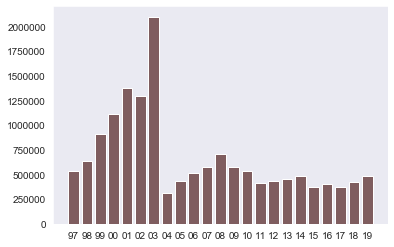

In [6]:
plt.xticks(np.arange(len(bars)),stavebni[stavebni.ctvrtleti==4]["rok"].apply(lambda x: str(x)[-2:]))
plt.bar(np.arange(len(bars)),bars,color='#7f5d5f')
plt.show()

Podíváme-li se na vývoj veličiny v čase, jasně vidíme, jak se projevují jednotlivé události. Jako nejvýraznější se zdá býti schválení zákona č. 423/2003 Sb., který snížil míru státní podpory z 25 % na 15 % ročně a její maximální roční výší ze 4500 Kč na 3000 Kč. Naopak obdobná změna, která přišla v roce 2011 a dále změnila 15 % na nových 10 % a nové maximum nastavila na 2000 Kč, se již v takové míře neprojevila, i když pokles můžeme zaznamenat i tam. Mimo tyto legislativní změny lze v datech dále vysledovat jasný efekt hospodářské krize, jejíž počátek časově odpovídá lokálnímu maximu v roce 2008.

## Penzijní spoření

Zde zvolíme velice podobný postup:

In [7]:
import pandas as pd
penzijni=pd.read_csv("https://data.mf.gov.cz/exports/penzijni_sporeni/csv").sort_values(["rok","ctvrtleti"]).reset_index()
penzijni.dtypes

index                       int64
rok                         int64
ctvrtleti                   int64
pocet_pp                    int64
pocet_dps                   int64
nove_pp                     int64
nove_dps                    int64
nove_dps_z_pp               int64
se_zamestnavatelem_pp       int64
se_zamestnavatelem_dps      int64
statni_pp                   int64
statni_dps                  int64
ucastniku_pp                int64
ucastniku_dps               int64
prumerny_statni_pp        float64
prumerny_statni_dps       float64
prumerny_ucastniku_pp     float64
prumerny_ucastniku_dps    float64
dtype: object

In [8]:
penzijni[["rok","ctvrtleti"]].head()

,rok,ctvrtleti
0,2000,4
1,2001,4
2,2002,4
3,2003,4
4,2004,4


In [9]:
penzijni[penzijni.ctvrtleti!=4][["rok","ctvrtleti"]].head()

,rok,ctvrtleti
8,2008,1
9,2008,2
10,2008,3
12,2009,1
13,2009,2


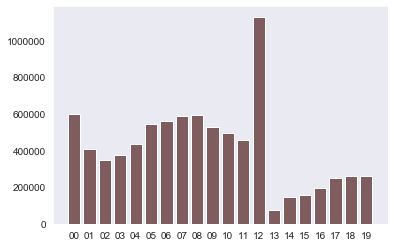

In [10]:
penzijni["nove_celkem"]=penzijni.nove_pp+penzijni.nove_dps
bars=penzijni[penzijni.ctvrtleti==4]["nove_celkem"]
plt.xticks(np.arange(len(bars)),penzijni[penzijni.ctvrtleti==4]["rok"].apply(lambda x: str(x)[-2:]))
plt.bar(np.arange(len(bars)),bars,color='#7f5d5f')
plt.show()

Stejně jako v předchozím případě se do počtu nových smluv promítla změna legislativy, kdy zanikla možnost uzavírat penzijní připojištění a vzniklo doplňkové penzijní spoření, které je, zjednodušeně řečeno, jeho funkční náhradou. Jak je však patrné z enormního nárůstu smluv v posledním roce, kdy bylo možné penzijní připojištění uzavírat (2012), není náhradou přesnou, a tak prosté napojení těchto dvou časových řad není zcela korektní. Podobně je zde zachycen i vliv zmíněné hospodářské krize v podobě poklesu po roce 2008.

## Srovnání

Výše zmíněná zjištění nám výrazně znesnadňují srovnání, jelikož se nějak musíme vypořádat s extrémními hodnotami způsobené změnami legislativy, které tyto datové sady značně odlišují. Na jednoduchém srovnání ukážeme, proč je to problém, a jak se výsledky změní, pokud provedeme některé úpravy.

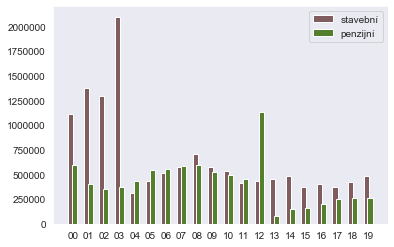

In [11]:
barWidth=0.25
bars1=stavebni[(stavebni.ctvrtleti==4) & (stavebni.rok>=2000)].nove_smlouvy
bars2=penzijni[penzijni.ctvrtleti==4].nove_celkem
plt.xticks([r + barWidth/2 for r in range(len(bars1))], \
           penzijni[penzijni.ctvrtleti==4]["rok"].apply(lambda x: str(x)[-2:]))
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
plt.bar(r1,bars1,color="#7f5d5f",width=1.3*barWidth,label="stavební")
plt.bar(r2,bars2, color="#547f2d",width=1.3*barWidth,label="penzijní",edgecolor='white')
plt.legend()
plt.show()

In [12]:
def print_corr(data1,data2): # korelační koeficient
    print(round(np.corrcoef(data1,data2)[0,1],4))

print_corr(stavebni[(stavebni.ctvrtleti==4) & (stavebni.rok>=2000)].nove_smlouvy,\
           penzijni[penzijni.ctvrtleti==4].nove_celkem)

print_corr(stavebni[(stavebni.ctvrtleti==4) & (stavebni.rok>=2005)].nove_smlouvy,\
           penzijni[(penzijni.ctvrtleti==4) & (penzijni.rok>=2005)].nove_celkem)

print_corr(stavebni[(stavebni.ctvrtleti==4) & (stavebni.rok>=2005) & (2011>=stavebni.rok)].nove_smlouvy,\
           penzijni[(penzijni.ctvrtleti==4) & (penzijni.rok>=2005) & (2011>=penzijni.rok)].nove_celkem)

0.0384
0.3331
0.6814


Jak graf, tak následné korelační koeficienty ukazují, že v prvních pěti letech je vlivem zmíněné změně v legislativě mezi daty výrazný nesoulad. Pokud se období do první změny stavebního spoření vynechá, podobnost je značnější. Stále je zde však změna v penzijním spoření, která po roce 2011 tento trend znovu výrazně mění. Ve výsledku je tak největší soulad v období mezi změnami, tedy od roku 2005 do roku 2011. Toto období však není příliš dlouhé a reflektuje především reakci na jeden konkrétní popud v podobě Velké recese.

Posledním místem, které stojí za zkoumání, je období po všech zmíněných změnách. To má tu výhodu, že v tomto období již máme k dispozici čtvrtletní data.

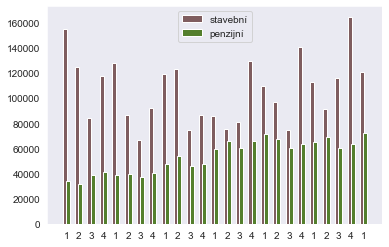

In [13]:
nove_celkem_v_obdobi=[]
for i in range(len(penzijni)):
    if penzijni.ctvrtleti[i]==1:
        nove=penzijni.nove_celkem[i]
    elif i-1 in penzijni[penzijni["rok"]==penzijni.rok[i]].ctvrtleti:
        nove=penzijni.nove_celkem[i]-penzijni.nove_celkem[i-1]
    else:
        nove=np.NaN
    nove_celkem_v_obdobi.append(nove)
penzijni["nove_celkem_v_obdobi"]=nove_celkem_v_obdobi

bars1=stavebni[stavebni.rok>=2014].nove_smlouvy_v_obdobi
bars2=penzijni[penzijni.rok>=2014].nove_celkem_v_obdobi
plt.xticks([r + barWidth/2 for r in range(len(bars1))], \
           penzijni[penzijni.rok>=2014]["ctvrtleti"].apply(lambda x: str(x)[-2:]))
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
plt.bar(r1,bars1,color="#7f5d5f",width=1.3*barWidth,label="stavební")
plt.bar(r2,bars2, color="#547f2d",width=1.3*barWidth,label="penzijní",edgecolor='white')
plt.legend()
plt.show()

In [14]:
print_corr(bars1,bars2)

0.0344


Z grafu je patrné, že obě časové řady vykazují značně odlišné trendy. To dokazuje taktéž velmi nízký korelační koeficient. Jedním z trendů, který můžeme sledovat, je sezónnost v datech o stavebním spoření. Zkusíme tuto vlastnost kvantifikovat průměrem v rámci stejného kvartálu:

In [15]:
print("stavební")
for i in range(1,5):
    print(round(np.mean(stavebni[(stavebni.rok>=2014)&(stavebni.ctvrtleti==i)]["nove_smlouvy_v_obdobi"]),0))
print("")
print(round(np.std(stavebni[stavebni.rok>=2014]["nove_smlouvy_v_obdobi"]),0)) # směrodatná odchylka
print("")
print("penzijní")
for i in range(1,5):
    print(round(np.mean(penzijni[(penzijni.rok>=2014)&(penzijni.ctvrtleti==i)]["nove_celkem_v_obdobi"]),0))
print("")
print(round(np.std(penzijni[penzijni.rok>=2014]["nove_celkem_v_obdobi"]),0))

stavební
118611.0
99549.0
82947.0
121827.0

25765.0

penzijní
55606.0
54738.0
50452.0
53535.0

12835.0


Zde vidíme, že tato sezónnost, tedy inklinace k uzavírání nových smluv v prvním a posledním kvartálu, spíše než v kvartálech jiných, se zdá při srovnání se směrodatnou odchylkou významná. Naopak v případě dat o penzijním spoření jsou rozdíly zanedbatelné, z čehož můžeme usuzovat, že na uzavírání takovýchto smluv nemá část roku přílišný vliv.

## Závěr

Z tohoto jednoduchého pohledu je jasně vidět, že ačkoli se předpoklad obdobného vývoje penzijního a stavebního spoření zdá na první pohled rozumný, nedá se v tomto případě na tuto intuici zcela spoléhat. To proto, že vývoj obou časových řad je značně ovlivněn změnami v legislativě, které zafungovaly jako pohnutka k uzavření smluv o pojištění bezprostředně před datem jejich účinnosti, čímž narušily celkový vývoj obou veličin. Taktéž lze v datech o stavebním spoření zaznamenat trend uzavírání smluv v prvním a posledním čtvrtletí roku, který v datech o spoření penzijním přítomen není. Jako jediné období obdobného vývoje obou veličin se ukázaly roky před a v průběhu Velké recese, kde byl růst a následný pokles značně korelovaný.

Zajisté by bylo možné takto nastíněný pohled dále rozšířit, významnost trendů otestovat za pomoci rigoróznějších postupů, či analýzu zlepšit užitím dalších datových zdrojů – to však již necháme na Vás, na uživatelích našich otevřených dat.